In [1]:
import os
from keras.models import Sequential
from keras import layers, regularizers, optimizers
from keras.optimizers import RMSprop
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
import requests
import json
import numpy as np
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.externals import joblib
from keras.preprocessing.sequence import TimeseriesGenerator

Using TensorFlow backend.
C:\Users\a.lunev\Anaconda3\envs\ML_GPU\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
#### Read from CSV
my_data = np.genfromtxt('e:\EURUSD-2000-2019.csv', delimiter=',', skip_header=1)
#my_data = np.concatenate((bin_days, my_data), axis=1)
my_data = np.delete(my_data, 1, 1)
#for i, data in enumerate(my_data):
#    my_data[i][0] = (datetime.strptime(str(data[0]), "%Y%m%d.0")).isoweekday()
#my_data = my_data[np.logical_not(my_data[:,0] == 7)]
#bin_days = to_categorical(my_data[:,0])
my_data = np.delete(my_data, 0, 1)

In [3]:
my_data[:,0] = my_data[:,1] - my_data[:,2]

In [4]:
my_data = np.delete(my_data, 1, 1)
my_data = np.delete(my_data, 1, 1)
my_data = np.delete(my_data, 2, 1)

In [5]:
my_data = np.delete(my_data, 0, 1)
my_data[0]

array([1.12292])

In [6]:
#### Read from DB
# auth_url = 'http://185.49.144.175/api/token/'
# bar_url = 'http://185.49.144.175/api/bars/?timeframe=1'
# headers = {'Content-type': 'application/json', 'Content-Encoding': 'utf-8'}
# data = {"username": "lim","password": "Serialnomberr3"}
# answer = requests.post(auth_url, data=json.dumps(data), headers=headers)
# response = answer.json()
# token = response['access']
# headers = {'Authorization': 'Bearer ' + token}
# answer = requests.get(bar_url, headers=headers)
# response = answer.json()
# f_data = np.zeros((len(response), 6))
# for i, bar in enumerate(response):
#     date = datetime.strptime( bar['time'], "%Y-%m-%dT%H:%M:%SZ" )
#     values = [date.isoweekday(), float(bar['open']), float(bar['close']), float(bar['high']), float(bar['low']), float(bar['tick_volume'])]
#     f_data[i, :] = values
# f_data = np.flip(f_data,0)
# bin_days = to_categorical(f_data[:,0])
# f_data = np.delete(f_data, 0, 1)
# f_data = np.concatenate((bin_days, f_data), axis=1)

In [7]:
# Normalize tick_volume
#f_data = np.delete(my_data, 4, 1)
# f_data = np.delete(f_data, 0, 1)
# f_data = np.delete(f_data, 0, 1)
# f_data = np.delete(f_data, 0, 1)
f_data = my_data
# for col in range(0,f_data.shape[-1]):
#     min = f_data[:1500000, col].min(axis=0)
#     max = f_data[:1500000, col].max(axis=0)
#     f_data[:, col] = (f_data[:, col] - min) / (max - min)

In [8]:
from matplotlib import pyplot as plt
close = my_data[:, 0]
plt.plot(range(len(close)), close)
plt.show()

<Figure size 640x480 with 1 Axes>

In [9]:
#Нормализация цены закрытия
minx = min(my_data)
maxx = max(my_data)
print(minx, maxx)
f_data = my_data
f_data = (f_data - minx) / (maxx - minx)

[1.03435] [1.60305]


In [10]:
my_data[0]

array([1.12292])

In [11]:
# Делаем массивы нужных размеров lookback должен быть >= delay
lookback=50
delay=10
re_data = f_data[:f_data.shape[0]//lookback*lookback,].reshape(-1, lookback)[:-1,]

In [12]:
data_float_y = my_data[:my_data.shape[0]//lookback*lookback].reshape(-1,lookback)[1:,]
data_bool_y = (data_float_y[:,0] - data_float_y[:,delay-1])

In [13]:
data_float_y.shape

(122798, 50)

In [14]:
dx_0 = 0.0001
dx_1 = 0.001
dx_2 = 0.004
print(max(abs(data_bool_y)), dx_0, dx_1, dx_2)
data_bool_y_1 = (abs(data_bool_y) <= dx_0).astype('int').reshape(-1,1)
data_bool_y_2 = ((abs(data_bool_y) > dx_0) * (abs(data_bool_y) <= dx_1) * (data_bool_y > 0)).astype('int').reshape(-1,1)
data_bool_y_3 = ((abs(data_bool_y) > dx_1) * (abs(data_bool_y) <= dx_2) * (data_bool_y > 0)).astype('int').reshape(-1,1)
data_bool_y_4 = ((abs(data_bool_y) > dx_2) * (data_bool_y > 0)).astype('int').reshape(-1,1)
data_bool_y_2_neg = ((abs(data_bool_y) > dx_0) * (abs(data_bool_y) <= dx_1) * (data_bool_y < 0)).astype('int').reshape(-1,1)
data_bool_y_3_neg = ((abs(data_bool_y) > dx_1) * (abs(data_bool_y) <= dx_2) * (data_bool_y < 0)).astype('int').reshape(-1,1)
data_bool_y_4_neg = ((abs(data_bool_y) > dx_2) * (data_bool_y < 0)).astype('int').reshape(-1,1)
data_cat_y = np.concatenate((data_bool_y_1, data_bool_y_2, data_bool_y_3, data_bool_y_4, data_bool_y_2_neg, data_bool_y_3_neg, data_bool_y_4_neg), axis=1)

0.013110000000000177 0.0001 0.001 0.004


In [15]:
f_data_train = re_data[:60000,]
f_data_val = re_data[2000000:2100000,]
f_data_test = re_data[60001:,]
f_data_train_y = data_cat_y[:60000,]
f_data_val_y = data_cat_y[2000000:2100000,]
f_data_test_y = data_cat_y[60001:,]

In [16]:
print(np.sum(data_cat_y), np.sum(data_cat_y, axis=0))

122798 [30815 40825  4940    73 41286  4773    86]


In [17]:
print(f_data_train[9], f_data_train_y[9])

[0.15315632 0.15303323 0.15278706 0.15264639 0.15282223 0.15276947
 0.15310357 0.15294531 0.15291015 0.15283981 0.1529629  0.15283981
 0.15276947 0.15245296 0.15201336 0.15264639 0.15280464 0.1529629
 0.15291015 0.15268155 0.15275189 0.15275189 0.15289256 0.15269914
 0.15273431 0.1530684  0.15287498 0.15280464 0.15248813 0.15275189
 0.15301565 0.15320907 0.15308599 0.15327941 0.15342008 0.15336733
 0.15329699 0.15336733 0.15331458 0.15329699 0.15347283 0.1534025
 0.15310357 0.15327941 0.15280464 0.15278706 0.15273431 0.15236504
 0.15240021 0.15315632] [0 0 0 0 1 0 0]


In [18]:
f_data_train_y.shape

(60000, 7)

In [19]:
f_data_train.shape

(60000, 50)

In [23]:
lookback = 30
step = 1
delay = 30
batch_size = 1
f_data_train = f_data[:999971,]
f_data_train_y = my_data[29:1000000,1] > f_data_train[:,1]
f_data_train_y = f_data_train_y.astype('int32') 
f_data_val = f_data[5000001:5099971,]
f_data_val_y = my_data[5000030:5100000,1] > f_data_val[:,1]
f_data_val_y = f_data_val_y.astype('int32')
f_data_test = f_data[-2800:-29,]
f_data_test_y = my_data[-2771:,1] > f_data_test[:,1]
f_data_test_y = f_data_test_y.astype('int32')
print(f_data_train.shape)
print(f_data_val.shape)
print(f_data_test.shape)
train_gen = TimeseriesGenerator(f_data_train, f_data_train_y, length=lookback, sampling_rate=step, batch_size=batch_size)
val_gen = TimeseriesGenerator(f_data_val, f_data_val_y, length=lookback, sampling_rate=step, batch_size=1)
test_gen = TimeseriesGenerator(f_data_test, f_data_test_y, length=lookback, sampling_rate=step, batch_size=1)
train_steps = len(train_gen)
val_steps = len(val_gen)
test_steps = len(test_gen)

(999971, 2)
(99970, 2)
(2771, 2)


In [24]:
train_x=[]
train_y=[]
for ts in train_gen:
    ts_r = ts[0].reshape(batch_size,-1)
    train_x.append(ts_r[0])
    train_y = ts[1]
val_x=[]
val_y=[]
for ts in val_gen:
    ts_r = ts[0].reshape(batch_size,-1)
    val_x.append(ts_r[0])
    val_y = ts[1]
test_x=[]
test_y=[]
for ts in test_gen:
    ts_r = ts[0].reshape(batch_size,-1)
    val_x.append(ts_r[0])
    val_y = ts[1]

In [156]:
checkpoint = ModelCheckpoint(filepath='best-weights.hdf5', monitor='val_acc', verbose=1, save_best_only=True)
model = Sequential()
# model.add(layers.CuDNNGRU(
#     units=250, 
#     input_shape=(None, f_data_train.shape[-1]),
#     return_sequences=False,
#     kernel_regularizer=None,
#     recurrent_regularizer=None,
#     bias_regularizer=None,
#     activity_regularizer=None))
# model.add(layers.Activation('tanh'))
# model.add(layers.Dropout(0.2))
model.add(layers.Dense(units=lookback, activation='relu', input_dim=f_data_train.shape[-1]))
model.add(layers.Dense(100, activation = 'relu'))
model.add(layers.Dense(100, activation = 'relu'))
model.add(layers.Dense(100, activation = 'relu'))
model.add(layers.Dense(units=7, activation='softmax'))
sgd = optimizers.Adam(lr=0.00000001)
#sgd = optimizers.SGD(lr=0.00001, momentum=0.0, nesterov=False)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
#history = model.fit_generator(train_gen, steps_per_epoch=train_steps, epochs=10, validation_data=val_gen, validation_steps=val_steps, callbacks=[checkpoint])
print('fitting')
history = model.fit(f_data_train, f_data_train_y, epochs=210, validation_split=0.3, callbacks=[checkpoint], verbose=1, batch_size=20)

fitting
Train on 42000 samples, validate on 18000 samples
Epoch 1/210
42000/42000 [==============================] - 26s 607us/step - loss: 1.9739 - acc: 0.0030 - val_loss: 1.9945 - val_acc: 0.0018

Epoch 00001: val_acc improved from -inf to 0.00178, saving model to best-weights.hdf5
Epoch 2/210
42000/42000 [==============================] - 21s 502us/step - loss: 1.9733 - acc: 0.0030 - val_loss: 1.9935 - val_acc: 0.0018

Epoch 00002: val_acc did not improve from 0.00178
Epoch 3/210
42000/42000 [==============================] - 22s 519us/step - loss: 1.9727 - acc: 0.0030 - val_loss: 1.9926 - val_acc: 0.0018

Epoch 00003: val_acc did not improve from 0.00178
Epoch 4/210
42000/42000 [==============================] - 22s 516us/step - loss: 1.9722 - acc: 0.0030 - val_loss: 1.9917 - val_acc: 0.0018

Epoch 00004: val_acc did not improve from 0.00178
Epoch 5/210
42000/42000 [==============================] - 22s 519us/step - loss: 1.9716 - acc: 0.0030 - val_loss: 1.9908 - val_acc: 0.0018

E

42000/42000 [==============================] - 25s 584us/step - loss: 1.9367 - acc: 0.0967 - val_loss: 1.9323 - val_acc: 0.0636

Epoch 00085: val_acc did not improve from 0.06361
Epoch 86/210
42000/42000 [==============================] - 25s 592us/step - loss: 1.9363 - acc: 0.0967 - val_loss: 1.9317 - val_acc: 0.0636

Epoch 00086: val_acc did not improve from 0.06361
Epoch 87/210
42000/42000 [==============================] - 25s 595us/step - loss: 1.9360 - acc: 0.0967 - val_loss: 1.9311 - val_acc: 0.0636

Epoch 00087: val_acc did not improve from 0.06361
Epoch 88/210
42000/42000 [==============================] - 25s 594us/step - loss: 1.9357 - acc: 0.0967 - val_loss: 1.9306 - val_acc: 0.0636

Epoch 00088: val_acc did not improve from 0.06361
Epoch 89/210
42000/42000 [==============================] - 25s 595us/step - loss: 1.9353 - acc: 0.0967 - val_loss: 1.9300 - val_acc: 0.0636

Epoch 00089: val_acc did not improve from 0.06361
Epoch 90/210
42000/42000 [===========================

42000/42000 [==============================] - 25s 605us/step - loss: 1.9131 - acc: 0.2193 - val_loss: 1.8917 - val_acc: 0.1771

Epoch 00168: val_acc did not improve from 0.17894
Epoch 169/210
42000/42000 [==============================] - 24s 575us/step - loss: 1.9128 - acc: 0.2351 - val_loss: 1.8913 - val_acc: 0.1771

Epoch 00169: val_acc did not improve from 0.17894
Epoch 170/210
42000/42000 [==============================] - 26s 607us/step - loss: 1.9126 - acc: 0.2484 - val_loss: 1.8908 - val_acc: 0.1771

Epoch 00170: val_acc did not improve from 0.17894
Epoch 171/210
42000/42000 [==============================] - 26s 617us/step - loss: 1.9123 - acc: 0.2630 - val_loss: 1.8903 - val_acc: 0.1771

Epoch 00171: val_acc did not improve from 0.17894
Epoch 172/210
42000/42000 [==============================] - 26s 621us/step - loss: 1.9120 - acc: 0.2706 - val_loss: 1.8899 - val_acc: 0.1797

Epoch 00172: val_acc improved from 0.17894 to 0.17967, saving model to best-weights.hdf5
Epoch 173/

In [157]:
model.save_weights('weights.last.hdf5')
model.load_weights('best-weights.hdf5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_77 (Dense)             (None, 30)                930       
_________________________________________________________________
dense_78 (Dense)             (None, 100)               3100      
_________________________________________________________________
dense_79 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_80 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_81 (Dense)             (None, 7)                 707       
Total params: 24,937
Trainable params: 24,937
Non-trainable params: 0
_________________________________________________________________


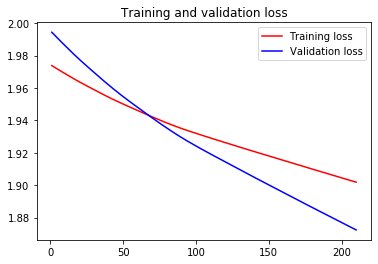

In [158]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [79]:
f_data_test[0]

array([0.24937577, 0.24937577, 0.24907684, 0.24912959, 0.24932302,
       0.24960436, 0.24962194, 0.24955161, 0.24956919, 0.24960436,
       0.24919993, 0.2496747 , 0.24944611, 0.24962194, 0.2496747 ,
       0.24946369, 0.24941094, 0.24941094, 0.24930543, 0.24921751,
       0.24939335, 0.24919993, 0.24900651, 0.248901  , 0.24888342,
       0.24898892, 0.24888342, 0.24876033, 0.24895375, 0.24895375,
       0.24895375, 0.24898892, 0.24891859, 0.24897134, 0.24897134,
       0.24891859, 0.24895375, 0.24886583, 0.24877791, 0.24919993,
       0.24928785, 0.2492351 , 0.24944611, 0.24956919, 0.24916476,
       0.24916476, 0.24883067, 0.24881308, 0.24900651, 0.24874275,
       0.24877791, 0.24858449, 0.24884825, 0.24888342, 0.24911201,
       0.248901  , 0.24881308, 0.24881308, 0.24842624, 0.24842624,
       0.2487955 , 0.24876033, 0.24860207, 0.24823281, 0.24795147,
       0.24777563, 0.24779321, 0.24767012, 0.24767012, 0.24751187,
       0.24772288, 0.24754704, 0.24754704, 0.2474767 , 0.24754

In [159]:
scores = model.predict(f_data_test)

In [160]:
for i in range(1000):
    print(np.argmax(scores[i]), np.argmax(f_data_test_y[i]))

1 2
1 1
1 5
1 0
1 4
1 2
1 1
1 4
1 3
1 2
1 5
1 5
1 2
1 5
1 4
1 1
1 0
1 1
1 5
1 5
1 0
1 2
1 4
1 5
1 5
1 2
1 1
1 4
1 4
1 0
1 1
1 5
1 0
1 1
1 1
1 4
1 0
1 4
1 4
1 1
1 0
1 4
1 2
1 1
1 4
1 5
1 1
1 4
1 2
1 1
1 5
1 4
1 2
1 1
1 1
1 2
1 4
1 4
1 5
1 4
1 0
1 1
1 1
1 5
1 6
1 1
1 5
1 4
1 0
1 5
1 1
1 2
1 1
1 0
1 0
1 1
1 0
1 4
1 1
1 1
1 4
1 0
1 2
1 1
1 4
1 1
1 4
1 0
1 4
1 1
1 1
1 0
1 4
1 4
1 1
1 4
1 0
1 1
1 4
1 5
1 1
1 1
1 4
1 4
1 4
1 1
1 4
1 5
1 1
1 5
1 1
1 2
1 1
1 5
1 1
1 4
1 4
1 1
1 1
1 0
1 4
1 1
1 5
1 4
1 1
1 4
1 4
1 1
1 1
1 1
1 0
1 0
1 0
1 1
1 1
1 1
1 4
1 1
1 4
1 1
1 1
1 5
1 1
1 1
1 1
1 2
1 5
1 4
1 1
1 1
1 4
1 2
1 1
1 0
1 4
1 5
1 4
1 4
1 2
1 2
1 5
1 1
1 0
1 1
1 4
1 1
1 4
1 1
1 4
1 4
1 4
1 4
1 0
1 1
1 0
1 4
1 1
1 4
1 2
1 1
1 1
1 4
1 0
1 4
1 0
1 4
1 0
1 1
1 1
1 4
1 0
1 5
1 3
1 0
1 4
1 6
1 4
1 5
1 2
1 0
1 5
1 4
1 1
1 1
1 4
1 1
1 1
1 4
1 1
1 1
1 0
1 5
1 4
1 5
1 4
1 4
1 5
1 0
1 1
1 5
1 1
1 6
1 2
1 1
1 2
1 1
1 4
1 4
1 1
1 1
1 4
1 5
1 2
1 1
1 4
1 1
1 4
1 4
1 5
1 5
1 2
1 5
1 5
1 2
1 4
1 5
1 2
1 1
1 0
1 1


In [201]:
dx = scores[0] - test_y[0]
scores_dx = scores - dx
dx

array([0.00191043])

In [199]:
print(scores[0])
print(test_y[0])

[1.1022304]
[1.10032]


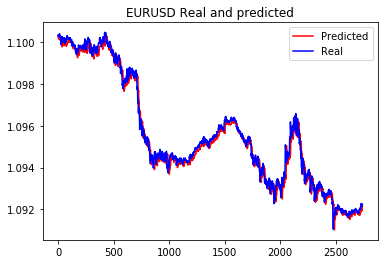

In [198]:
#### from matplotlib import pyplot as plt
plt.plot(range(len(scores)), scores_dx, 'r', label='Predicted')
plt.plot(range(test_steps), test_y, 'b', label='Real')
plt.legend(['Predicted', 'Real'])
plt.title('EURUSD Real and predicted')
plt.show()

In [ ]:
from matplotlib import pyplot as plt
plt.plot(range(len(scores)), scores, 'r', label='Predicted')
#plt.legend(['Predicted', 'Real'])
plt.title('EURUSD Predicted')
plt.show()

In [59]:
model.save_weights('weights.last.hdf5')